In [ ]:
# Zdroje kódov a inšpirácie:
#
# Na imputáciu chýbajúcich hodnôt pomocou algoritmu KNN bol použitý KNNImputer podľa dokumentácie knižnice Scikit-learn:
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html
#
# Kódovanie kategórií LabelEncoder: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
#
# Normalizácia číselných premenných bola vykonaná pomocou MinMaxScaler podľa oficiálnej dokumentácie Scikit-learn:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
#
# Vyváženie dátových tried kombinovanou metódou SMOTETomek bolo inšpirované dokumentáciou knižnice imbalanced-learn:
# https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html
#
# Výber najdôležitejších príznakov bol vykonaný pomocou SelectKBest:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
#
# Tréning modelu Stacking
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html
#
# ROC-AUC krivka
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
#
# Takisto treba spomenúť, že inšpiráciou pre tento kód bol kurz "Python for Data Science and Machine Learning Bootcamp" od Jose Portilla (Udemy)
#
# Kombinácia predikcií modelov do jednej matice pomocou np.column_stack():
# https://numpy.org/doc/stable/reference/generated/numpy.column_stack.html
#
# Spojenie matice predikcií s pôvodnými vlastnosťami pomocou np.hstack():
# https://numpy.org/doc/stable/reference/generated/numpy.hstack.html
#
# Interpretácia modelu pomocou SHAP:
# - Dokumentácia SHAP: https://shap.readthedocs.io/en/latest/
# - Explainer: https://shap.readthedocs.io/en/latest/generated/shap.Explainer.html
# - Explanation: https://shap.readthedocs.io/en/latest/generated/shap.Explanation.html
# - Summary plot: https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html
# - Waterfall plot: https://shap.readthedocs.io/en/latest/generated/shap.plots.waterfall.html
# - Inšpirácia z Kaggle: https://www.kaggle.com/code/dansbecker/shap-values  
# - Inšpirácia z Youtube: https://www.youtube.com/watch?v=2xlgOu22YgE&t=331s&ab_channel=ADataOdyssey

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 
import matplotlib.patches as mpatches 
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

In [2]:
stroke = pd.read_csv('healthcare-dataset-stroke-data.csv')
st = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
#delete id
stroke.drop(columns = 'id', inplace = True)

In [4]:
#bmi and glucose level outliers calculation 
Q1_gluc = stroke["avg_glucose_level"].quantile(0.25)
Q3_gluc = stroke["avg_glucose_level"].quantile(0.75)
IQR_gluc = Q3_gluc - Q1_gluc
lower_bound_gluc = Q1_gluc - 1.5 * IQR_gluc
upper_bound_gluc = Q3_gluc + 1.5 * IQR_gluc
print("Lower Bound: {0}, Upper Bound: {1}".format(lower_bound_gluc, upper_bound_gluc))

Q1_bmi = stroke["bmi"].quantile(0.25)
Q3_bmi = stroke["bmi"].quantile(0.75)
IQR_bmi = Q3_bmi - Q1_bmi
lower_bound_bmi = Q1_bmi - 1.5 * IQR_bmi
upper_bound_bmi = Q3_bmi + 1.5 * IQR_bmi
print("Lower Bound: {0}, Upper Bound: {1}".format(lower_bound_bmi, upper_bound_bmi))

Lower Bound: 21.977500000000006, Upper Bound: 169.35750000000002
Lower Bound: 9.099999999999998, Upper Bound: 47.5


In [5]:
#work with outliers(first example)
#def gluc(value):
 #   i = upper_bound_gluc
  #  if(value > i):
   #     return i
    #else:
     #   return value

#def bmi(value):
 #   i = upper_bound_bmi
  #  if(value > i):
   #     return i
    #else: 
     #  return value

#stroke['bmi'] = stroke['bmi'].apply(bmi)
#stroke['avg_glucose_level'] = stroke['avg_glucose_level'].apply(gluc)

In [6]:
#delete outliers(second example)
stroke = stroke[(stroke['bmi'] <= 47.5) & (stroke['avg_glucose_level'] <= 169.35750000000002)]

In [7]:
stroke.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [8]:
#deleting gender=other line
stroke = stroke[stroke['gender'] != 'Other']
stroke.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4260 entries, 2 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4260 non-null   object 
 1   age                4260 non-null   float64
 2   hypertension       4260 non-null   int64  
 3   heart_disease      4260 non-null   int64  
 4   ever_married       4260 non-null   object 
 5   work_type          4260 non-null   object 
 6   Residence_type     4260 non-null   object 
 7   avg_glucose_level  4260 non-null   float64
 8   bmi                4260 non-null   float64
 9   smoking_status     4260 non-null   object 
 10  stroke             4260 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 399.4+ KB


In [9]:
#encoding categorical atrributes

In [10]:
#gender
stroke = stroke.copy()
gender_mapping = {'Male': 0, 'Female': 1}
stroke['gender'] = stroke['gender'].map(gender_mapping)

In [11]:
stroke.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4260 entries, 2 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4260 non-null   int64  
 1   age                4260 non-null   float64
 2   hypertension       4260 non-null   int64  
 3   heart_disease      4260 non-null   int64  
 4   ever_married       4260 non-null   object 
 5   work_type          4260 non-null   object 
 6   Residence_type     4260 non-null   object 
 7   avg_glucose_level  4260 non-null   float64
 8   bmi                4260 non-null   float64
 9   smoking_status     4260 non-null   object 
 10  stroke             4260 non-null   int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 399.4+ KB


In [12]:
#ever_married
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
stroke['ever_married'] = encoder.fit_transform(stroke['ever_married'])
stroke['ever_married'] = stroke['ever_married'].astype('int64')

In [13]:
#Resdidence_type
encoder = LabelEncoder()
stroke['Residence_type'] = encoder.fit_transform(stroke['Residence_type'])
stroke['Residence_type'] = stroke['Residence_type'].astype('int64')
stroke.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4260 entries, 2 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4260 non-null   int64  
 1   age                4260 non-null   float64
 2   hypertension       4260 non-null   int64  
 3   heart_disease      4260 non-null   int64  
 4   ever_married       4260 non-null   int64  
 5   work_type          4260 non-null   object 
 6   Residence_type     4260 non-null   int64  
 7   avg_glucose_level  4260 non-null   float64
 8   bmi                4260 non-null   float64
 9   smoking_status     4260 non-null   object 
 10  stroke             4260 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 399.4+ KB


In [14]:
stroke.head() 

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2,0,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1
6,0,74.0,1,1,1,Private,0,70.09,27.4,never smoked,1
7,1,69.0,0,0,0,Private,1,94.39,22.8,never smoked,1
9,1,78.0,0,0,1,Private,1,58.57,24.2,Unknown,1
10,1,81.0,1,0,1,Private,0,80.43,29.7,never smoked,1


In [15]:
#change float age to int
stroke['age'] = stroke['age'].astype('int64')

In [16]:
#one-hot-encoding implementation for work_type and smoking_status
stroke = pd.get_dummies(stroke, columns = ['work_type', 'smoking_status'])

In [17]:
#handling bmi missing values
from sklearn.impute import KNNImputer
original_dtypes = stroke.dtypes
imputer = KNNImputer(n_neighbors=5)
stroke = pd.DataFrame(imputer.fit_transform(stroke), columns=stroke.columns)
#restore original data types
stroke = stroke.astype(original_dtypes)

In [18]:
stroke.isna().sum()

gender                            0
age                               0
hypertension                      0
heart_disease                     0
ever_married                      0
Residence_type                    0
avg_glucose_level                 0
bmi                               0
stroke                            0
work_type_Govt_job                0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
smoking_status_Unknown            0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64

In [19]:
stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4260 entries, 0 to 4259
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          4260 non-null   int64  
 1   age                             4260 non-null   int64  
 2   hypertension                    4260 non-null   int64  
 3   heart_disease                   4260 non-null   int64  
 4   ever_married                    4260 non-null   int64  
 5   Residence_type                  4260 non-null   int64  
 6   avg_glucose_level               4260 non-null   float64
 7   bmi                             4260 non-null   float64
 8   stroke                          4260 non-null   int64  
 9   work_type_Govt_job              4260 non-null   bool   
 10  work_type_Never_worked          4260 non-null   bool   
 11  work_type_Private               4260 non-null   bool   
 12  work_type_Self-employed         42

In [20]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from collections import Counter
from imblearn.over_sampling import ADASYN
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score#
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SequentialFeatureSelector

#separation of features(X) and target variable(y)
X = stroke.drop('stroke', axis = 1)
y = stroke['stroke']

#feature scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi',
       'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'])

#Smote Tomek + train-test-split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.3, random_state=42, stratify = y
)

#count of test part heck
y_test.value_counts()

sm = SMOTETomek(sampling_strategy=0.5,random_state = 42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

#class distribution check
print("Original class distribution:", Counter(y_train))
print("Resampled class distribution:", Counter(y_train_resampled))

Original class distribution: Counter({0: 2887, 1: 95})
Resampled class distribution: Counter({0: 2878, 1: 1434})


C:\Users\maxor\AppData\Local\Temp\ipykernel_43688\2088689897.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  stroke_balanced.set_xticklabels(['Nie', 'Áno'])


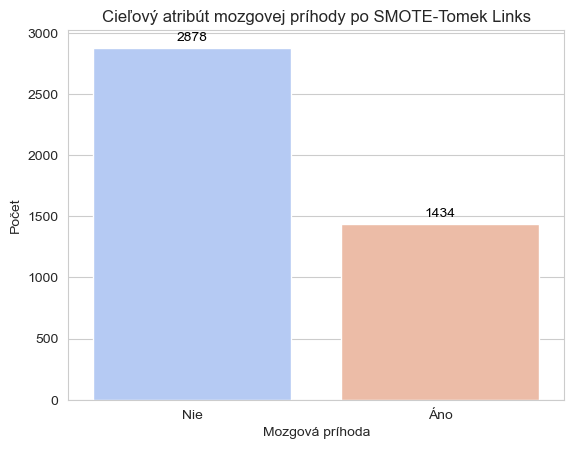

In [21]:
import matplotlib.patches as mpatches 
sns.set_style("whitegrid") 

#plotting the distribution of classes in y_resampled
stroke_balanced = sns.countplot(x=y_train_resampled, hue = y_train_resampled, palette = 'coolwarm')

#add numbers to bars
for p in stroke_balanced.patches:
    height = p.get_height()
    if height > 0:  
        stroke_balanced.annotate(f'{int(height)}', 
                                (p.get_x() + p.get_width() / 2., height),
                                ha='center', va='bottom', 
                                fontsize=10, color='black', 
                                xytext=(0, 3), textcoords='offset points')

plt.title('Cieľový atribút mozgovej príhody po SMOTE-Tomek Links')
plt.xlabel('Mozgová príhoda')
plt.ylabel('Počet')
plt.legend().remove()
stroke_balanced.set_xticklabels(['Nie', 'Áno'])
plt.show()

In [22]:
#Modelovanie

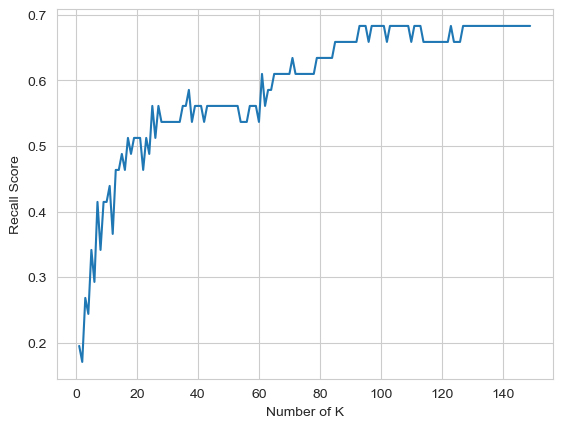

Najlepšie K: 93, Recall: 0.6829

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.82      0.89      1237
           1       0.11      0.68      0.19        41

    accuracy                           0.81      1278
   macro avg       0.55      0.75      0.54      1278
weighted avg       0.96      0.81      0.87      1278



In [23]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
knn_est = KNeighborsClassifier()
sfs_knn = SequentialFeatureSelector(estimator=knn_est, 
                                n_features_to_select=5,  
                                direction="backward", scoring='recall', tol=0.001, cv=3)  
sfs_knn = sfs_knn.fit(X_train_resampled, y_train_resampled)
sfs_knn.get_feature_names_out()
X_train_selected = sfs_knn.transform(X_train_resampled)
X_test_selected = sfs_knn.transform(X_test)

scores = []
k_values = range(1, 150)
for i in  k_values:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_selected,y_train_resampled)
    y_pred = knn.predict(X_test_selected)
    scores.append(recall_score(y_test, y_pred))

import matplotlib.pyplot as plt
plt.plot(range(1,150),scores)
plt.ylabel('Recall Score')
plt.xlabel('Number of K')
plt.show()

best_k = k_values[np.argmax(scores)]
best_recall = max(scores)
print(f"Najlepšie K: {best_k}, Recall: {best_recall:.4f}")

knn = KNeighborsClassifier(n_neighbors=best_k) #prva=70 druha=95
knn.fit(X_train_selected, y_train_resampled)
knn_pred = knn.predict(X_test_selected)
print("\nClassification Report:")
print(classification_report(y_test, knn_pred))

In [24]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=5, n_jobs=-1, class_weight='balanced', random_state=42)
sfs_rf = SequentialFeatureSelector(estimator=rf, 
                                n_features_to_select=5,  
                                direction="backward", scoring='recall', tol=0.001, cv=3)  
sfs_rf = sfs_rf.fit(X_train_resampled, y_train_resampled)
selected_features = sfs_rf.get_feature_names_out()
selected_features
X_train_selected = pd.DataFrame(sfs_rf.transform(X_train_resampled), columns=selected_features)
X_test_selected = pd.DataFrame(sfs_rf.transform(X_test), columns=selected_features)
rf.fit(X_train_selected, y_train_resampled)
rf_pred = rf.predict(X_test_selected)
print("\nClassification Report:")
print(classification_report(y_test, rf_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.71      0.83      1237
           1       0.07      0.63      0.12        41

    accuracy                           0.71      1278
   macro avg       0.53      0.67      0.47      1278
weighted avg       0.95      0.71      0.80      1278



In [25]:
#AdaBoost
base_estimator = DecisionTreeClassifier(max_depth=1)#RidgeClassifier()#very slow=SVC(probability=True, kernel="linear")#not bad = LogisticRegression()
ada_est = AdaBoostClassifier(estimator=base_estimator, random_state=42)
sfs_ada = SequentialFeatureSelector(estimator=ada_est, 
                                n_features_to_select=5,  
                                direction="backward", scoring='recall', tol=0.001, cv=3, n_jobs=-1)  
sfs_ada = sfs_ada.fit(X_train_resampled, y_train_resampled)
sfs_ada.get_feature_names_out()
X_train_selected = sfs_ada.transform(X_train_resampled)
X_test_selected = sfs_ada.transform(X_test)

param_grid_ada = {
    'n_estimators': [10, 50, 100, 300,500],                   
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],                  
}

grid = GridSearchCV(AdaBoostClassifier(estimator=base_estimator, random_state=42), 
                    param_grid=param_grid_ada, 
                    verbose=0, 
                    scoring='recall',
                    cv=5, 
                    n_jobs=-1)

grid.fit(X_train_selected, y_train_resampled)


ada = grid.best_estimator_
ada_pred = ada.predict(X_test_selected)
print("\nClassification Report:")
print(classification_report(y_test, ada_pred))
print(recall_score(y_test, ada_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.65      0.78      1237
           1       0.07      0.83      0.13        41

    accuracy                           0.65      1278
   macro avg       0.53      0.74      0.46      1278
weighted avg       0.96      0.65      0.76      1278

0.8292682926829268


In [26]:
#SVM
svm_est = SVC(C=10, class_weight='balanced', gamma=1, probability=True, random_state=42) 
sfs_svm = SequentialFeatureSelector(estimator=svm_est, 
                                n_features_to_select=5,
                                direction="backward", scoring='recall', 
                                tol=0.001, cv=3, n_jobs=-1)  
sfs_svm = sfs_svm.fit(X_train_resampled, y_train_resampled)
sfs_svm.get_feature_names_out()
X_train_selected = sfs_svm.transform(X_train_resampled)
X_test_selected = sfs_svm.transform(X_test)
from sklearn.model_selection import GridSearchCV

param_grid_svm = {
    'C': [0.001, 10, 100],                   
    'gamma': [1, 0.1, 0.01, 'scale', 'auto'],                  
} 
grid = GridSearchCV(estimator=SVC(random_state=42, probability=True, class_weight='balanced'), 
                    param_grid=param_grid_svm, verbose=0, cv=5, n_jobs=-1, scoring='recall')
grid.fit(X_train_selected, y_train_resampled)
svm = grid.best_estimator_
svm_pred = svm.predict(X_test_selected)
print("\nClassification Report:")
print(classification_report(y_test, svm_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.76      0.86      1237
           1       0.08      0.59      0.13        41

    accuracy                           0.76      1278
   macro avg       0.53      0.67      0.50      1278
weighted avg       0.95      0.76      0.83      1278



In [27]:
print(recall_score(y_test, svm_pred))

0.5853658536585366


In [28]:
#stacking 
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif

#filter approach feature selection
selector = SelectKBest(score_func=f_classif, k=4)
X_train_selected = selector.fit_transform(X_train_resampled, y_train_resampled)
X_test_selected = selector.transform(X_test)

In [29]:
#define base estimators
estimators = [
            ('knn', knn),
            ('svm', svm),
            ('rf', rf),
            ('ada', ada) ]

#define final estimator and stack model
meta_model = LogisticRegression(random_state=42)
stack_model = StackingClassifier(estimators = estimators, final_estimator=meta_model,
                                passthrough=True)

from sklearn.model_selection import GridSearchCV
#hyperparameters tuning
param_grid = {
    'final_estimator__C': [0.01, 0.1, 1, 10],
    'final_estimator__class_weight': ['balanced', None],
    'final_estimator__solver': ['liblinear']
}

grid_stack = GridSearchCV(stack_model, param_grid, scoring='recall', cv=3, n_jobs=-1)
grid_stack.fit(X_train_selected, y_train_resampled)

#best stack model choice
best_stack_model = grid_stack.best_estimator_
y_test_pred = best_stack_model.predict(X_test_selected)
y_test_proba = best_stack_model.predict_proba(X_test_selected)[:, 1]

print("Best parameters:", grid_stack.best_params_)
print("Recall:", recall_score(y_test, y_test_pred))
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

Best parameters: {'final_estimator__C': 0.01, 'final_estimator__class_weight': 'balanced', 'final_estimator__solver': 'liblinear'}
Recall: 0.8292682926829268
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.66      0.79      1237
           1       0.08      0.83      0.14        41

    accuracy                           0.67      1278
   macro avg       0.53      0.75      0.47      1278
weighted avg       0.96      0.67      0.77      1278



Confusion Matrix:
[[820 417]
 [  7  34]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.66      0.79      1237
           1       0.08      0.83      0.14        41

    accuracy                           0.67      1278
   macro avg       0.53      0.75      0.47      1278
weighted avg       0.96      0.67      0.77      1278


Accuracy Score:
0.6682316118935837

Precsion:
0.07538802660753881

Recall:
0.8292682926829268

AUC: 0.8296626377743163


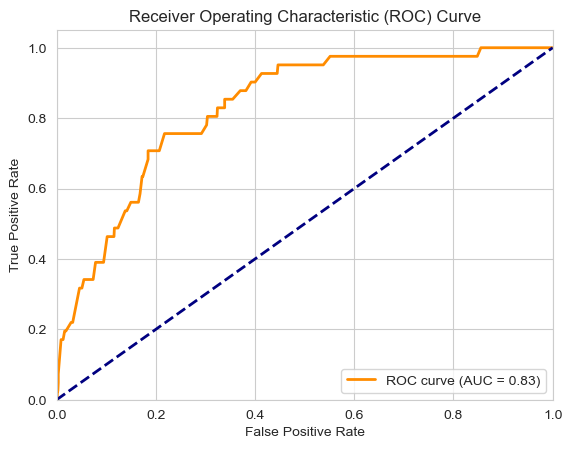

In [30]:
#confusion matrix + metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_test_pred))

print("\nPrecsion:")
print(precision_score(y_test, y_test_pred))

print("\nRecall:")
print(recall_score(y_test, y_test_pred))

roc_auc = roc_auc_score(y_test, y_test_proba)
print("\nAUC:", roc_auc)

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

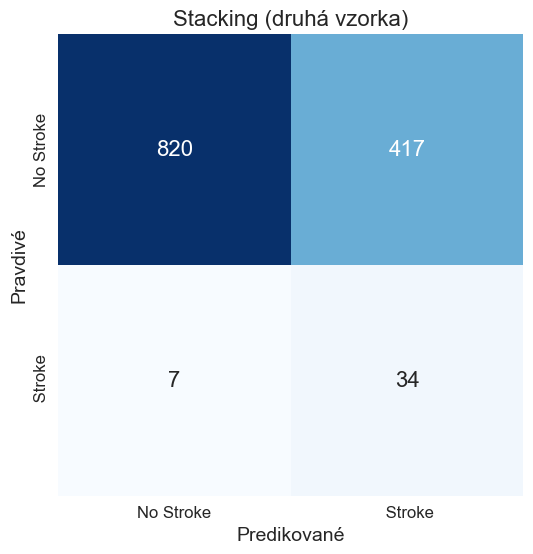

In [31]:
#confusion matrix plot
cm  = confusion_matrix(y_test, y_test_pred)
classes = ['No Stroke', ' Stroke']

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar = False, annot_kws={"size": 16})

#druhá prvá
plt.title('Stacking (druhá vzorka)', fontsize=16) 
plt.ylabel('Pravdivé', fontsize=14)
plt.xlabel('Predikované', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

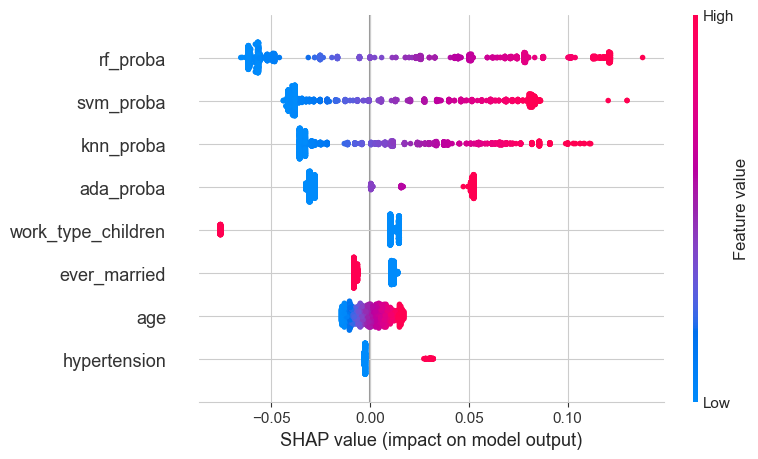

In [32]:
import shap

#combination of features and outputs from base models
meta_features_test = np.column_stack([
    best_stack_model.named_estimators_['knn'].predict_proba(X_test_selected)[:, 1],
    best_stack_model.named_estimators_['svm'].predict_proba(X_test_selected)[:, 1],
    best_stack_model.named_estimators_['rf'].predict_proba(X_test_selected)[:, 1],
    best_stack_model.named_estimators_['ada'].predict_proba(X_test_selected)[:, 1]
])

X_meta_test = np.hstack([meta_features_test, X_test_selected])
feature_names = ['knn_proba', 'svm_proba', 'rf_proba', 'ada_proba'] + list(selector.get_feature_names_out())
explainer = shap.Explainer(best_stack_model.final_estimator_.predict_proba, X_meta_test)
shap_values = explainer(X_meta_test)

#stacking summary plot
shap.summary_plot(shap_values[:, :, 1], X_meta_test, feature_names=feature_names)

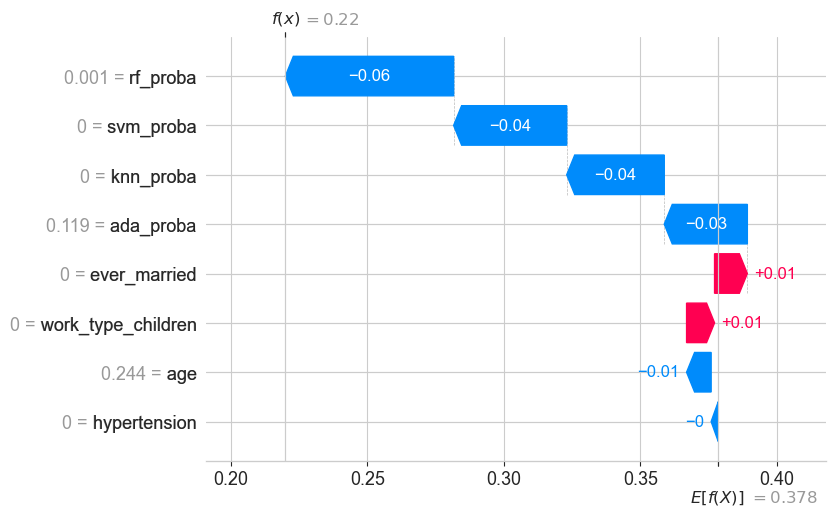

In [33]:
#create shap explanation for positive class
expl_waterfall = shap.Explanation(
    values=shap_values[0, :, 1],
    base_values=shap_values.base_values[1],
    data=X_meta_test[0],
    feature_names=feature_names
)

#SHAP waterfall plot creation
shap.plots.waterfall(expl_waterfall, max_display=10)

In [34]:
#k = 2 → Recall: 0.800
#k = 3 → Recall: 0.800
#k = 4 → Recall: 0.787
#k = 5 → Recall: 0.787
#k = 6 → Recall: 0.800
#k = 7 → Recall: 0.800
#k = 8 → Recall: 0.747
#k = 9 → Recall: 0.747
#k = 10 → Recall: 0.640
#k = 11 → Recall: 0.627
#k = 12 → Recall: 0.640
#k = 13 → Recall: 0.547

In [35]:
#k = 4 → Recall: 0.829
#k = 5 → Recall: 0.683
#k = 6 → Recall: 0.683
#k = 7 → Recall: 0.659
#k = 8 → Recall: 0.610
#k = 9 → Recall: 0.415
#k = 10 → Recall: 0.415
#k = 11 → Recall: 0.439
#k = 12 → Recall: 0.244